In [13]:
import pandas as pd

element = []
with open("./metadata.tsv") as f:
    header = []
    for line in f:
        line = line.strip()
        if not header:
            header = line.split("\t")
        else:
            element.append(dict(zip(header, line.split("\t"))))

df = pd.DataFrame(element)
df.index = df.Gallica.apply(lambda x: x.split("/")[-1])
df = df[["Date"]]
for _, row in df.iterrows():
    if not row.Date.isnumeric():
        if "-" in row.Date:
            row.Date = int(sum(map(int, row.Date.split("-"))) / 2)
        else:
            row.Date = 1710
    else:
        row.Date = int(row.Date)

Text(5.069444444444445, 0.5, 'Number of books')

<Figure size 1000x500 with 0 Axes>

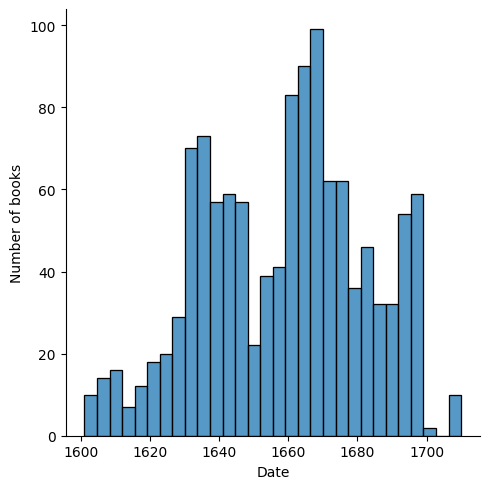

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax = sns.displot(df.loc[df.index.drop_duplicates()], x="Date", bins=30)
plt.ylabel("Number of books")
# df.drop_duplicates(df.).shape


In [29]:
df["Tokens"] = 0
df["Text"] = ""
import glob
import os
import lxml.etree as et
import tqdm.notebook as tqdm

xsl = et.XSLT(et.fromstring("""<xsl:stylesheet xmlns:xsl="http://www.w3.org/1999/XSL/Transform"
    xmlns:xs="http://www.w3.org/2001/XMLSchema"
    exclude-result-prefixes="xs"
    xmlns:tei="http://www.tei-c.org/ns/1.0"
    version="1.0">
    <xsl:output method="text"/>
    <xsl:template match="node()">
        <xsl:apply-templates select="node()"/>
    </xsl:template>
    <xsl:template match="text()">
        <xsl:copy />
    </xsl:template>
    <xsl:template match="tei:teiHeader"/>
    <xsl:template match="tei:fw"/>
</xsl:stylesheet>"""))

import re

spaces = re.compile(r"( +)|(\n{2, })")

for tei_file in tqdm.tqdm(glob.glob("./tei-long-s/*"), position=0):
    path = os.path.basename(tei_file).replace(".tar.gz", "").replace(".tei.xml", "")
    toks = 0
    text = []
    xml = et.parse(tei_file)
    text = spaces.sub(" ", str(xsl(xml))).strip()
    df.loc[df.index == path, "Tokens"] = len(text.split())
    df.loc[df.index == path, "Text"] = text

  0%|          | 0/620 [00:00<?, ?it/s]

In [31]:
df.to_csv("contents.csv")

<Axes: xlabel='Date', ylabel='Accumulated Tokens'>

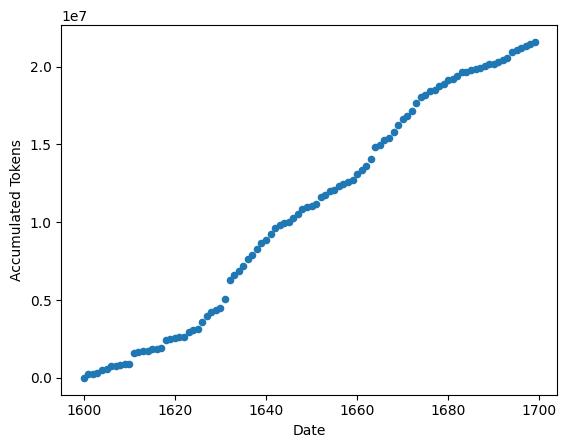

In [30]:
counts = [0]*100
for idx, row in df.iterrows():
    if row.Date < 1700:
        for i in range(row.Date-1600, 100):
            counts[i] += row.Tokens

pd.DataFrame([{"Date": idx + 1600, "Accumulated Tokens": cnt} for idx, cnt in enumerate(counts)]).plot.scatter(x="Date", y="Accumulated Tokens")